# **Group 37: DSCI 100 - Physical Characteristics of Tennis Players Influencing their Likelihood of Winning Matches**

----------------------------------------------------------


## Research question: do tennis players' physical characteristics influence the likelihood of winning a game?


## Introduction
Our project aims to identify the likelihood of winning (or losing) tennis matches in the ATP tournament based on a player’s physical characteristics such as height and age. Our dataset is taken from Jeff Sackmann’s tennis database on GitHub and compiles ATP tournament match data from 2020. The ATP Tour is a global top-level male tennis tour organised by the Association of Tennis Professionals (ATP). 

While our dataset contains 50 columns and almost 7000 rows, we are whittling this down to focus on exclusively physical characteristic data of players. We have also created a new binary variable, `win_lose`, which indicates the overall result of a tennis match. Our project will focus on a $K$-nearest neighbours classification analysis of our two classifier variables and our one predictor variable. We will try to predict the outcome of  a match based on players' age and height.



In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RCurl)
options(repr.matrix.max.rows = 6)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:
#reading the dataset into Jupyter
x <- getURL("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2020.csv")
match_data <- read.csv(text = x)
match_data

tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2020-8888,Atp Cup,Hard,24,A,20200106,300,104925,NA,,⋯,51,39,6,10,6,8,2,9055,1,9985
2020-8888,Atp Cup,Hard,24,A,20200106,299,105138,NA,,⋯,35,21,6,9,5,10,10,2335,34,1251
2020-8888,Atp Cup,Hard,24,A,20200106,298,104925,NA,,⋯,57,35,25,14,6,11,2,9055,5,5705
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2020-7485,Antwerp,Hard,32,A,20201019,128,126203,7,,⋯,37,30,5,9,3,5,28,1670,33,1402
2020-7485,Antwerp,Hard,32,A,20201019,129,144750,NA,Q,⋯,45,29,5,10,7,11,90,748,74,838
2020-7485,Antwerp,Hard,32,A,20201019,130,200005,NA,,⋯,32,26,7,9,2,4,38,1306,172,353


In [5]:
#Split match_data into two tables based on whether a player won or lost their match
#Add a variable indicating said win or loss
#Select for the variables of interest: height and age and match_result
#Rename height and age column names to remove redundancy and improve consistency
match_data_winner <- match_data |> 
                    mutate(match_result = "win") |>
                    select(winner_ht, winner_age, match_result) |>
                    rename(ht = winner_ht, age = winner_age)

match_data_loser <- match_data |> 
                    mutate(match_result = "lose") |>
                    select(loser_ht, loser_age, match_result) |>
                    rename(ht = loser_ht, age = loser_age)

#Recombine the two tables into one
match_data_tidy <- bind_rows(match_data_winner, match_data_loser)
match_data_tidy

ht,age,match_result
<int>,<dbl>,<chr>
188,32.6,win
183,31.7,win
188,32.6,win
⋮,⋮,⋮
211,23.1,lose
178,21.5,lose
180,26.6,lose


In [6]:
#Seperating the Data into training and test sets
match_split <- initial_split(match_data_tidy, prop = 0.75, strata = match_result)
match_train <- training(match_split)
match_test <- testing(match_split)

In [7]:
#Check number of missing values in each column of the table ONLY USING TRAINING DATA
num_na <- match_train |> 
            summarize_all(~sum(is.na(.)))
num_na

ht,age,match_result
<int>,<int>,<int>
36,0,0


Warning message:
“Removed 36 rows containing non-finite values (stat_bin).”


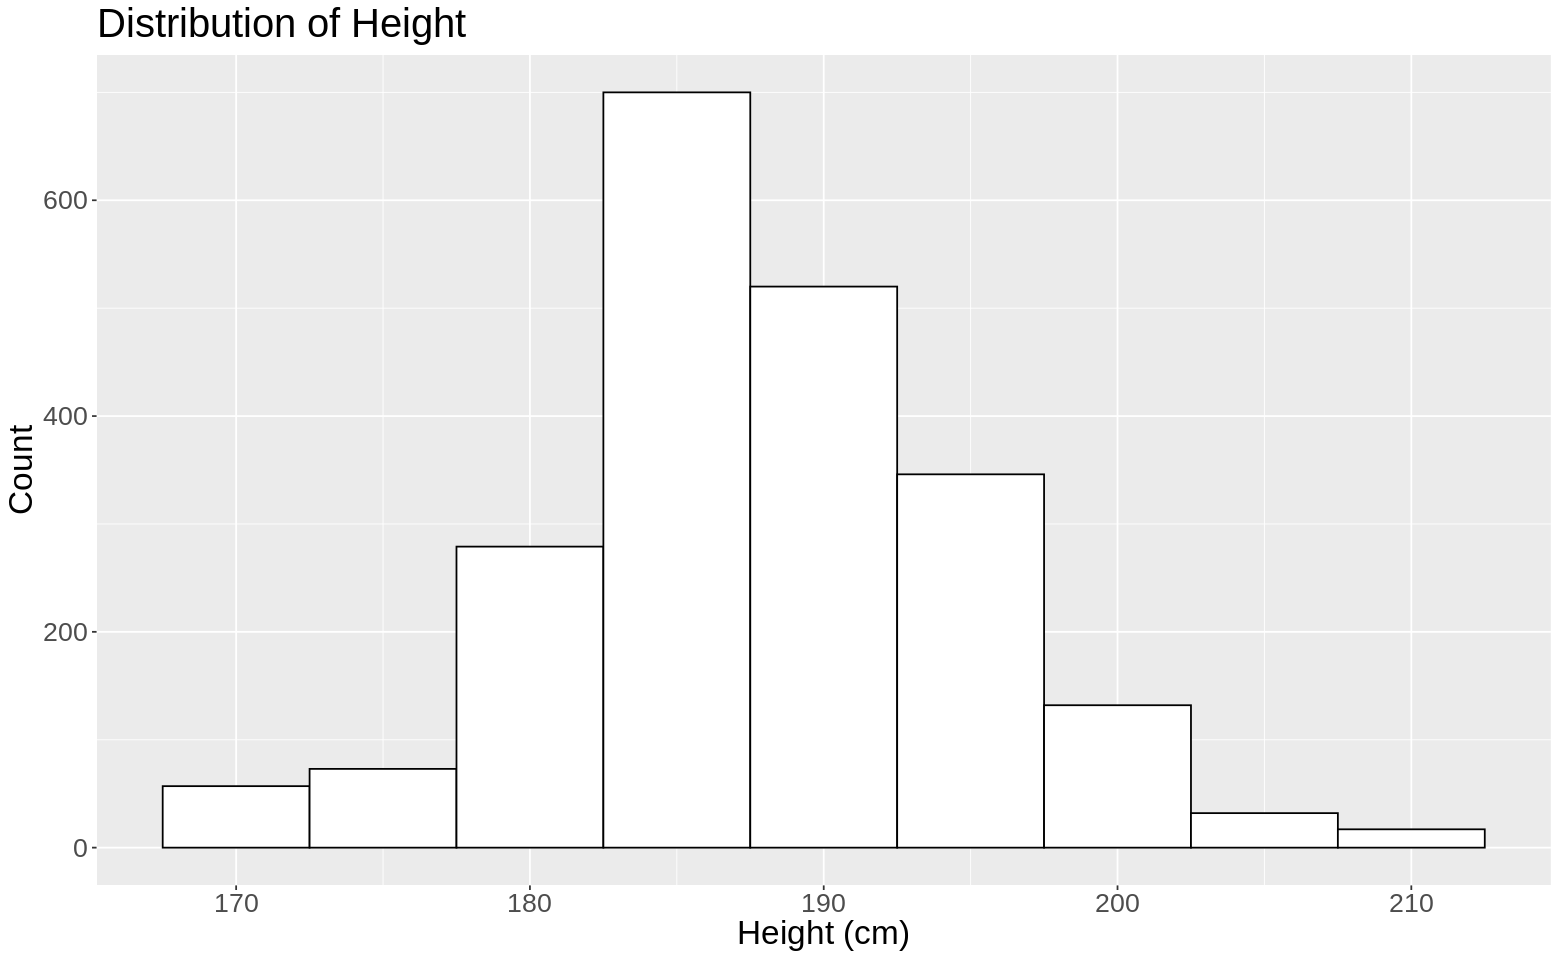

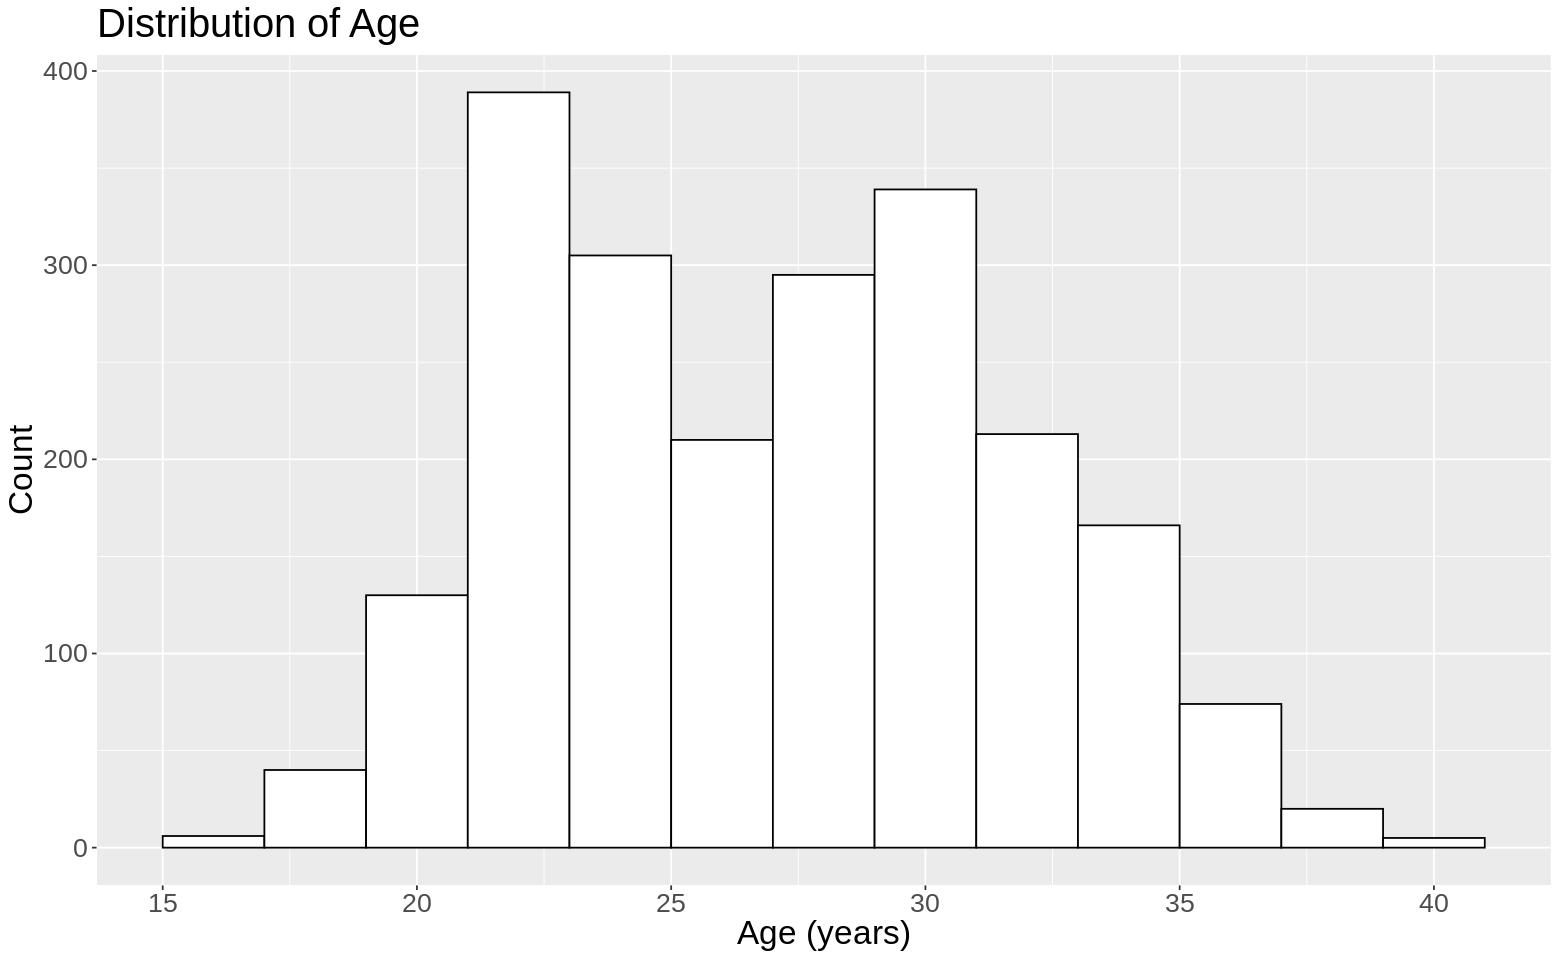

In [8]:
#Histograms of the height and age variable distributions ONLY USING TRAINING DATA
options(repr.plot.width = 13, repr.plot.height =8)
prelim_hist_height <- ggplot(data = match_train, aes(x = ht))+
                geom_histogram(binwidth = 5, color = "black", fill = "white")+
                labs(x = "Height (cm)", y = "Count")+
                ggtitle("Distribution of Height")+
                theme(text = element_text(size = 20))

prelim_hist_height

prelim_hist_age <- ggplot(data = match_train, aes(x = age))+
                geom_histogram(binwidth = 2, color = "black", fill = "white")+
                labs(x = "Age (years)", y = "Count")+
                ggtitle("Distribution of Age")+
                theme(text = element_text(size = 20))
prelim_hist_age

# Method

For our group we decided to do a classification where we are going to predict if an athlete is going to win or lose based on their height and age. Therefore, we will first tidy the data and choose several variables for us to predict the outcome. The reason why we chose height and age is because we think height and age are the most relevant data that directly affect an athlete’s outcome. What we are planning to do is to visualize the two variables first to see the influence and relevance on our prediction. As the percentage of winning and losing are mostly half and half, we would prefer to use K=3 or 5, to be more accurate in predicting. Then, we will use the classification model to classify and predict the possible outcomes. Below are the graphs of age and height in relation to the end result of winning and losing.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



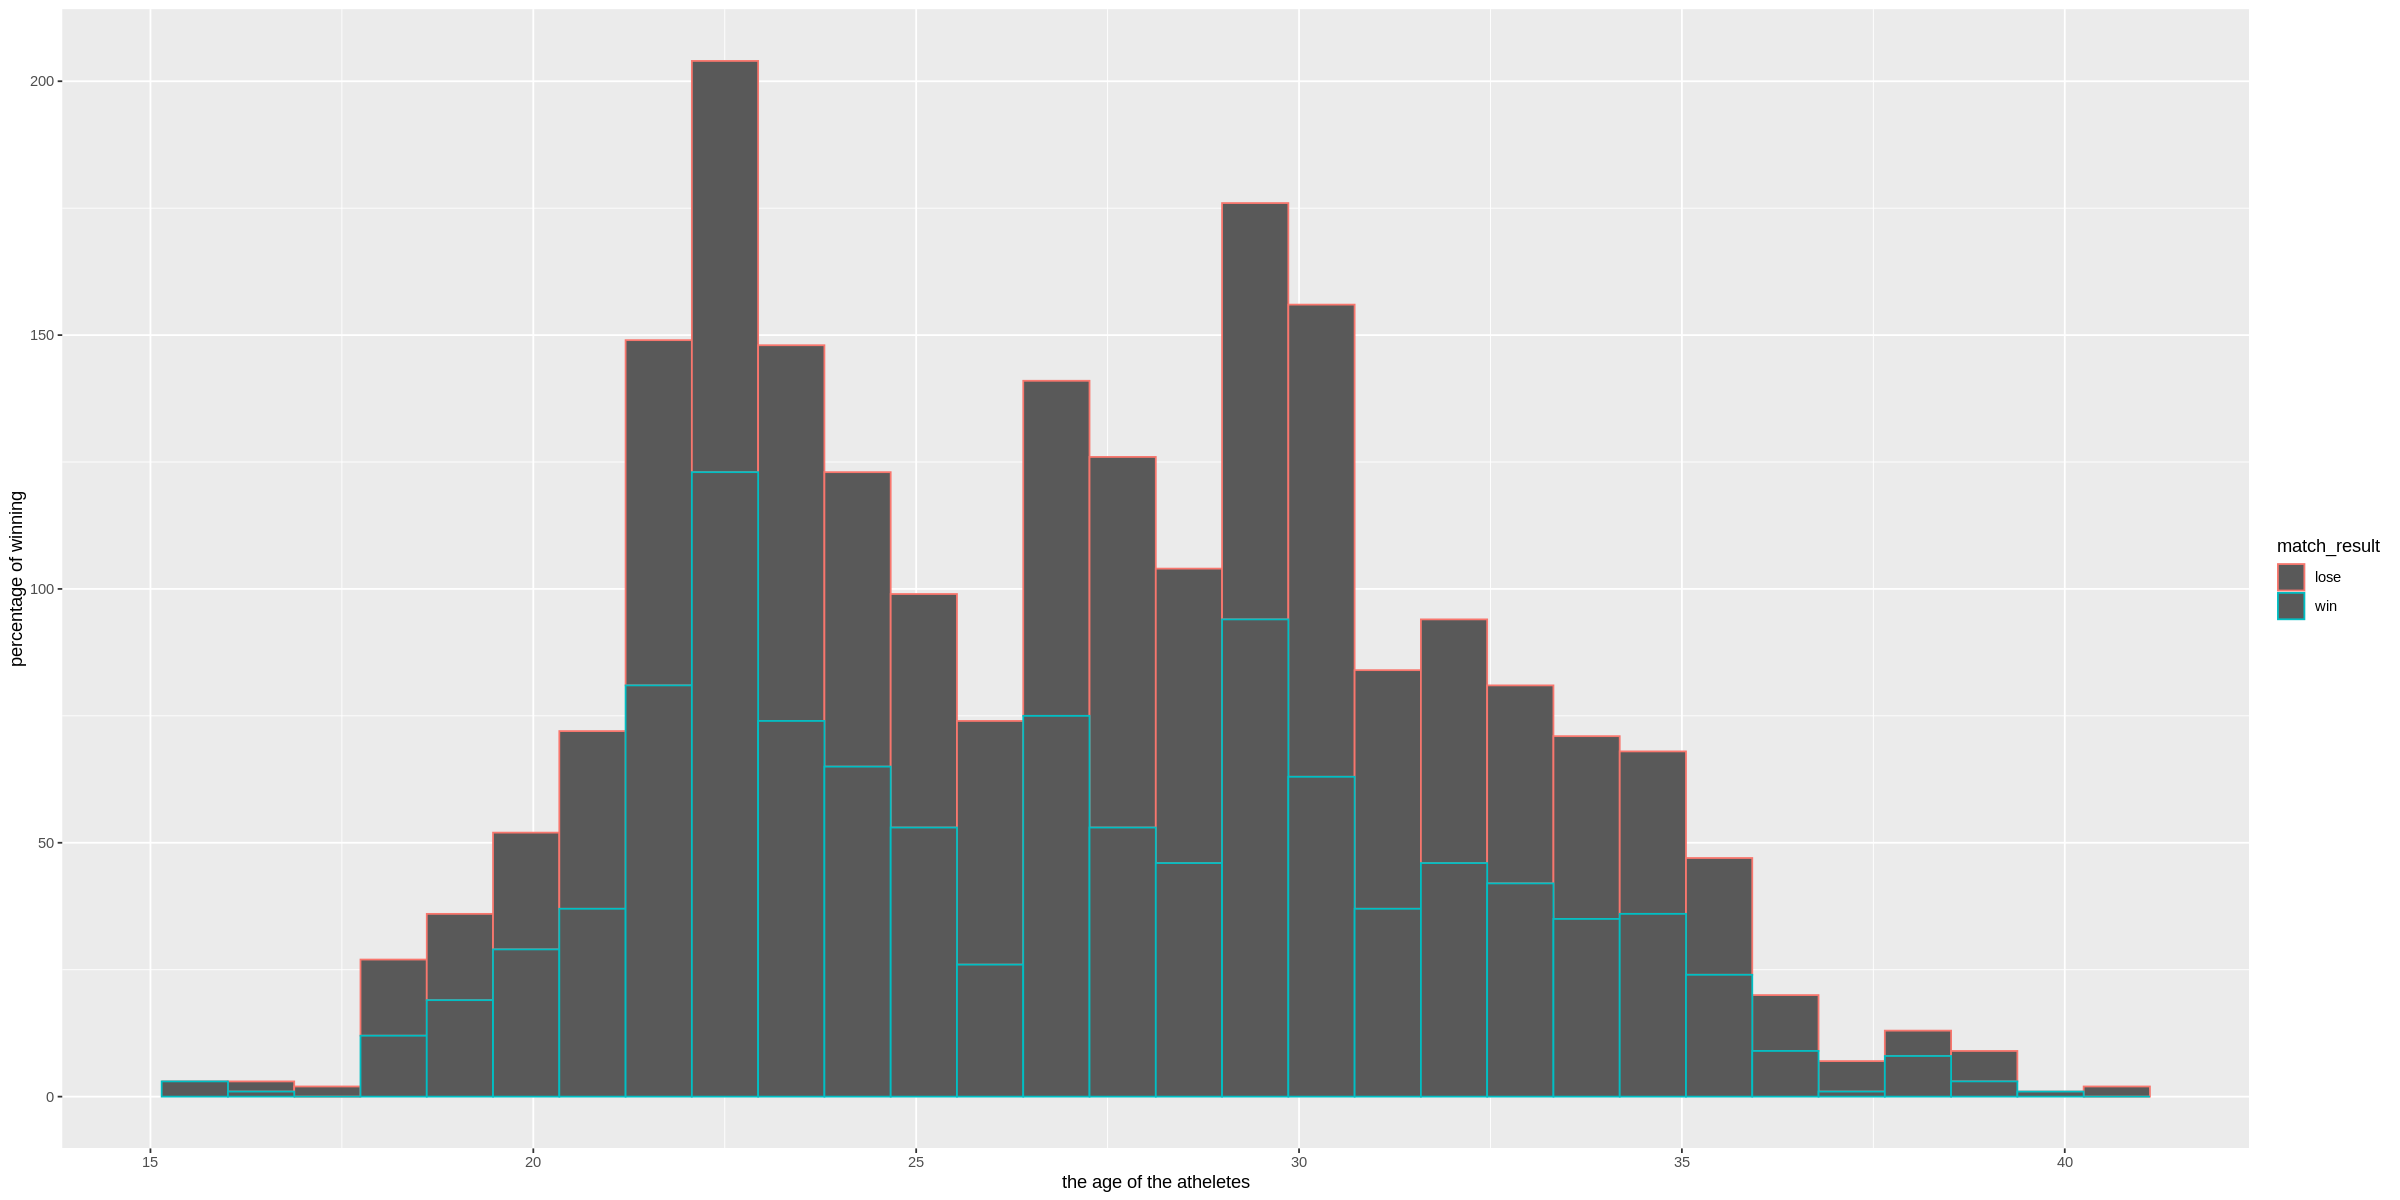

In [11]:
options(repr.plot.width = 20, repr.plot.height = 10)

relation_age <- match_train |>
ggplot(aes(x = age, color = match_result)) + geom_histogram() +
labs(x = "the age of the atheletes", y = "percentage of winning")

relation_age

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



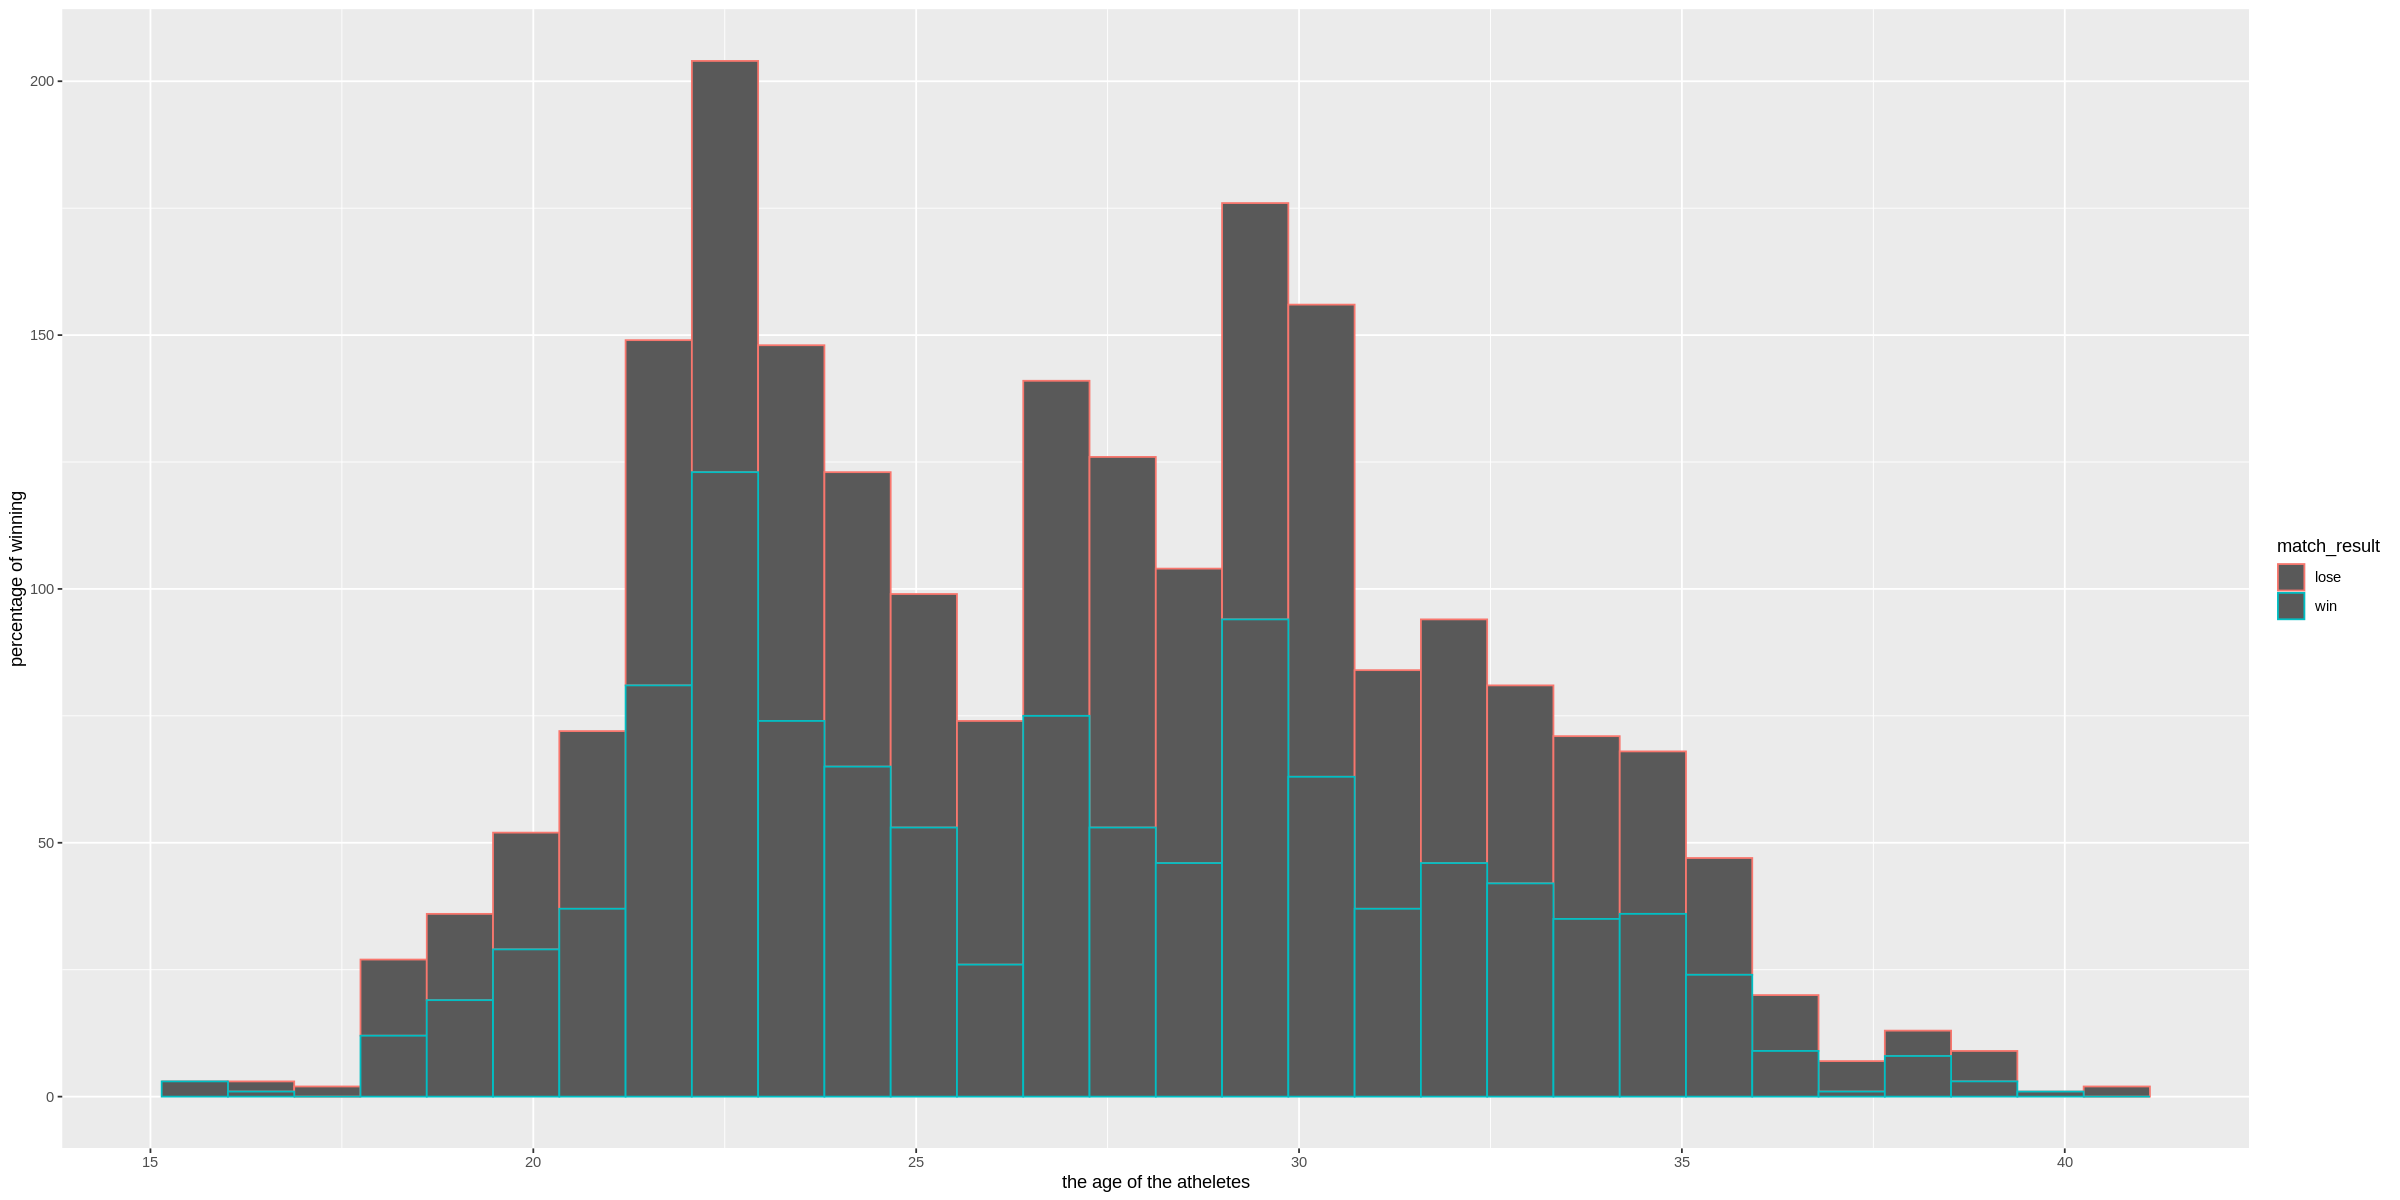

In [12]:
options(repr.plot.width = 20, repr.plot.height = 10)

relation_height <- match_train |>
ggplot(aes(x = ht, color = match_result)) + geom_histogram() +
labs(x = "the height of the atheletes", y = "percentage of winning")

relation_age

## Expected Outcomes and Significance

We expect to find that the players’ physical characteristics are closely linked to their likelihood of winning. For height, we believe that the taller players will be more likely to win because their height will translate to longer arms and legs; this would give them a greater advantage than those who are shorter. For example, a player with shorter legs will have a harder time running across the court compared to someone with longer legs, putting them at a disadvantage. For age, we expect that older players will be less likely to win because older players are more liable to injuries and health conditions, impacting their athletic abilities. Overall, we expect individuals who are tall and of a younger age to be the ideal players to win more matches. Such findings could have an impact on the future of ATP tournaments, which may reveal the uncontrollable advantages certain players have over others. This could lead to us asking what else may be unfairly impacting players’ tennis playing capabilities: mental health history, social background, or other physical characteristics. We may be able to look further into how severely such differences have on the likelihood of certain players winning or losing.